<a href="https://colab.research.google.com/github/elsioantunes/proc-video/blob/main/procVideoLab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Processamento de video LAB 2
Objetivos:


1. Blur images with various low pass filters $\color{#00DD00}{\text{OK}}$
2. Apply custom-made filters to images (2D convolution) $\color{#00DD00}{\text{OK}}$






##Open image

Mounted at /content/drive


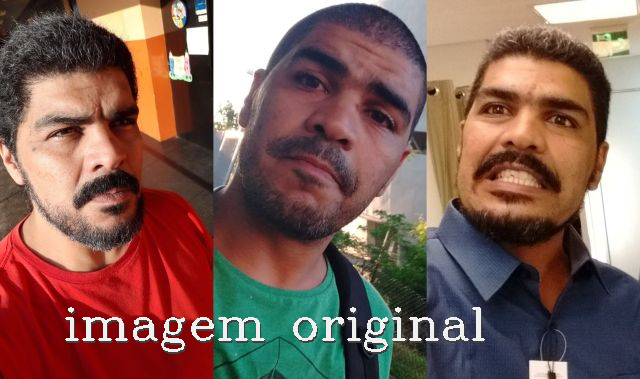

height:  379 width:  640 channels:  3


In [2]:
import numpy as np
import random
import cv2 as cv
from base64 import b64encode
from google.colab.patches import cv2_imshow
from google.colab import drive
from IPython.display import HTML
 
#https://docs.opencv.org/4.5.2/d6/d6e/group__imgproc__draw.html
 
drive.mount('/content/drive')
img = cv.imread('/content/drive/MyDrive/((UFABC))/(proc video)/elsios.jpg')
height, width, channels = img.shape
 
myBgColor = (255, 245, 245)
 
def newEmptyImg(w=width, h=height, corRGB=myBgColor):
    b, g, r = corRGB
    emptyImg = np.zeros((h, w, 3), np.uint8)
    emptyImg[:, :] = (r, g, b)
    return emptyImg
 
def overlay(bg, img, x, y):
    h, w, _ = img.shape
    bg[y:h + y, x:w + x] = img
    return bg
 
def tableShow(m):
    hl, wl, h, w, _ = np.array(m).shape
    bg = newEmptyImg(w*wl + 5*wl+5, h*hl + 5*hl+5, myBgColor)
    for i, lin in enumerate(m):
        for j, col in enumerate(lin):
            bg = overlay(bg, col, 5 + (5 + width) * j, 5 + (5 + height) * i)
    return bg
 
def text(img, txt, w = int(width/10), h = int(9*height/10)):
    imgtmp = img.copy()
    cv.putText(imgtmp, txt, (w, h), cv.FONT_HERSHEY_COMPLEX, 1.5, (64, 64, 64), 2)
    cv.putText(imgtmp, txt, (w-1, h-2), cv.FONT_HERSHEY_COMPLEX, 1.5, (240, 240, 240), 2)
    return imgtmp
 
def show(img, title=""):
    return cv2_imshow(text(img, title))
 
nullSrc = newEmptyImg()
 
show(img, "imagem original")
print("height: ", height, "width: ", width, "channels: ", channels)

## Salt and Pepper

Primeira coisa implementar um filtro noise do tipo salt and pepper para demonstrar o funcionamento (e a impressionante eficácia) do filtro de mediana.

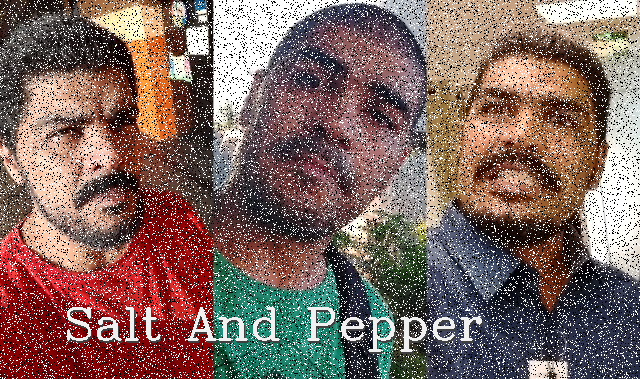

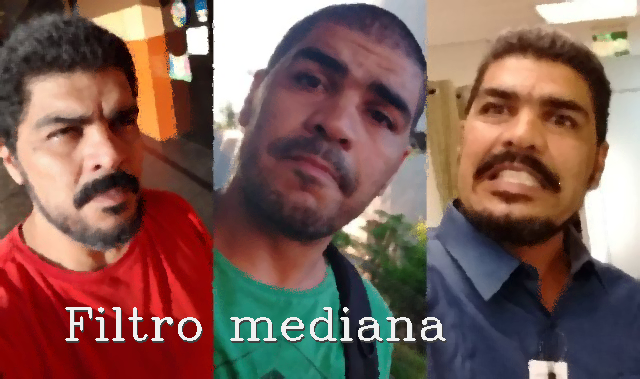

In [ ]:
def saltAndPepper(img, ratio):
    ratio = ratio/2
    h, w, c = img.shape
    tmp = img.copy()
    for i in  range(h):
        for j in range(w):
            rnd = np.random.random()
            if rnd < ratio: tmp[i][j] = (0, 0, 0)
            elif rnd > (1 - ratio): tmp[i][j] = (255, 255, 255)
    return tmp

def medianFilter(img, b):
    h, w, c = img.shape
    copyImg = img.copy()
    borderImg = cv.copyMakeBorder(img, b, b, b, b, cv.BORDER_REFLECT_101)
    for i in  range(h):
        for j in range(w):
            tmp = []
            for p in range(2*b+1):
                for q in range(2*b+1):
                    tmp.append(tuple(borderImg[i+p][j+q]))
            tmp.sort() # não muito eficiente né?
            copyImg[i][j] = tmp[2*b*(b+1)]
    return copyImg

noiseImg = saltAndPepper(img, .2)
show(text(noiseImg, "Salt And Pepper"))

medianImg = medianFilter(noiseImg, 2)
show(text(medianImg, "Filtro mediana"))

O ruído do tipo salt and pepper tem este nome porque se parece com o efeito de sujar uma superfície jogando sal (pixels brancos) e pimenta (pixels pretos). Tal ruído, conhecido no Brasil como 'chuvisco' pode ser ocasionado por erros de transmissão de sinal.

O filtro de mediana é um dos tipos de filtro 'passa baixa' que se valem da característica desse tipo de ruído que, ou SALTa em picos do pixel ou o apaga de vez, ou seja, variações muito bruscas no sinal que fariam um filtro de médias não ser tão bem sucedidos.

O filtro de mediana funciona substituindo cada pixel pela mediana da vizinhança. Efetivamente, fazemos uma lista com os pixels de uma janela em volta de cada pixel, ordenamos e pegamos o valor central.

O filtro de mediana é muito eficiente para retirada de ruídos do tipo salt and pepper. A desvantagem está no dano causado a linhas e bordas. Mas pode-se obter bons ajustes de custo-benefício.

## Ruído Gaussiano
Já para ruídos aditivos como o ruído Gaussiano o melhor é utilizar filtros de média normal ou Gaussiano para capturar a distribuição de erros impressa em todos (e não só em alguns) pixels da imagem.

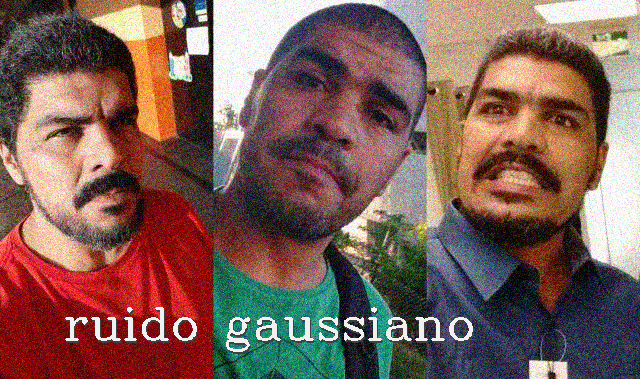

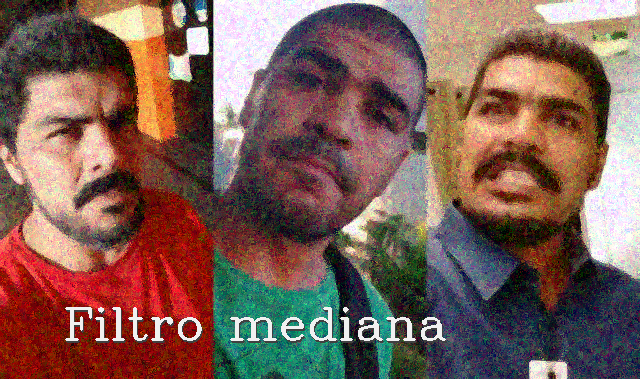

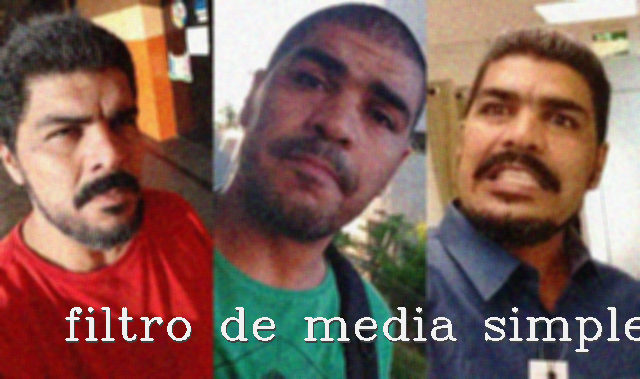

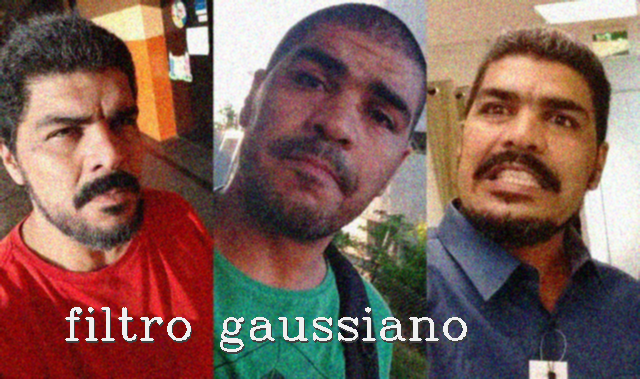

In [ ]:
def gaussianNoise(img, std):
    mean = 0
    h, w, c = img.shape
    gnoiseImg = img + np.random.normal(mean, std, img.shape)
    gnoiseImg = np.clip(gnoiseImg, 0, 255)
    return gnoiseImg

def meanFilter(img, b):
    h, w, c = img.shape
    copyImg = img.copy()
    borderImg = cv.copyMakeBorder(img, b, b, b, b, cv.BORDER_REFLECT_101)
    for i in  range(h):
        for j in range(w):
            tmp = (0, 0, 0)
            n = 0
            for p in range(2*b+1):
                for q in range(2*b+1):
                    tmp = tmp + borderImg[i+p][j+q]
                    n = n + 1
            copyImg[i][j] = tmp/n
    return copyImg

def gaussianFilter(img):
    return cv.GaussianBlur(img, (3,3), 0)


gaussianNoiseImg = gaussianNoise(img, 24)
show(text(gaussianNoiseImg, "ruido gaussiano"))

medianImg = medianFilter(gaussianNoiseImg, 2)
show(text(medianImg, "Filtro mediana"))

meanImg = meanFilter(gaussianNoiseImg, 2)
show(text(meanImg, "filtro de media simples"))


meanImg = gaussianFilter(gaussianNoiseImg)
show(text(meanImg, "filtro gaussiano"))

O filtro de média simples retirou boa parte do ruído, mas suavizou demais a imagem fazendo perder detalhes. O filtro Gaussiano, por suavisar mais o centro da janela do que as bordas, conservou melhor os detalhes o mais nítido quanto possível.

Eu diria que o filtro de mediana PIOROU a imagem, mostrando que os filtros indicados para cada caso dependem de cada caso.

## Convolução em 2D

* Convolução é uma operação matemática de transformação linear que, a partir de duas funções retorna (em uma terceira) a soma do produto dessas funções em função do deslocamento entre elas.

* Tal operação tem aplicações em processamento de imagens, videos, telecomunicação, sensores e outras tecnologias baseadas em manipulação de sinais. 

* Em especial, em processamento de imagens a convolução é utilizada na aplicação de filtros como suavização e também (de forma mais interessante) no mapeamento de características com ações

* Segundo o teorema, convolução em um domínio (por exemplo, do tempo tempo) equivale a multiplicação ponto a ponto no outro domínio (por exemplo, da frequência)

* A partir da aplicação de kernels com configurações específicas para cada filtro como: ***find edge*** que ressalta os limites dos detalhes; ***blur*** que faz o contrário, suavizando as mudanças de forma e simulando efeito de desfoque; diversos outros filtros são possiveis. 

* O algoritmo padrão para cálculo da convolução, como visto na função `medianFilter` definida neste trabalho, tem complexidade computacional quadrática; No caso, um pouco menos pois operamos cada pixel da imagem com cada pixel do kernel que é sempre menor; 

* Segundo estudos, lançando mão do teorema da convolução 
e da transformada rápida de Fourier, a complexidade de algoritmos envolvendo multiplicação de funções pode ser reduzida a `O(n log n)`. A prova se baseia numa forma normalizada da transformada de Fourier. Outras normalizações diferem em fatores de escalamento constantes.

In [ ]:
def medianFilter(img, b):
    h, w, c = img.shape
    copyImg = img.copy()
    borderImg = cv.copyMakeBorder(img, b, b, b, b, cv.BORDER_REFLECT_101)
    for i in  range(h):
        for j in range(w):
            tmp = []
            for p in range(2*b+1):
                for q in range(2*b+1):
                    tmp.append(tuple(borderImg[i+p][j+q]))
            tmp.sort() # não muito eficiente né?
            copyImg[i][j] = tmp[2*b*(b+1)]
    return copyImg

def meanFilter(img, b):
    h, w, c = img.shape
    copyImg = img.copy()
    borderImg = cv.copyMakeBorder(img, b, b, b, b, cv.BORDER_REFLECT_101)
    for i in  range(h):
        for j in range(w):
            tmp = (0, 0, 0)
            n = 0
            for p in range(2*b+1):
                for q in range(2*b+1):
                    tmp = tmp + borderImg[i+p][j+q]
                    n = n + 1
            copyImg[i][j] = tmp/n
    return copyImg

Especificamente, a implementação prática percorre cada pixel da imagem com um loop para cada linha aninhado a um loop para cada pixel; Cria algum tipo de acumulador para guardar o resultado do processamento do pixel corrente; itera-se sobre as linhas e colunas do kernel atualizando o valor do acumulador em função dos valores do pixel e da posição atual da matriz do kernel, aplicando a uma nova imagem os valores correspondentes de cada pixel.

Dentre os cuidados necessários está o de alocar memória suficiente para a cosntrução da segunda imagem pois o processamento inline sofreria com a alteração do pixel anterior; Também deve-se preocupar com o que acontece com os limites das bordas da imagem já que o processamento depende da vizinhança que nelas precisa ser considerado se interpreta como um espelhamento, um deslocamento ou ainda o encaixe com a borda contrária da imagem. Dado que os resultados de multiplicação dos valores do kernel com os de cada pixel da imagem podem estar fora da faixa de cores permitida, faz-se necessário também uma normalização destes valores.

## Image Kernels explained visually


De forma didática e interativa o site setosa.io <https://setosa.io/ev/image-kernels/> mostra na prática como se dá a multiplicação dos valores da matriz. Conforme o usuário move o mouse, verifica na matriz e na imagem formada a transformação de acordo com o kernel definido.
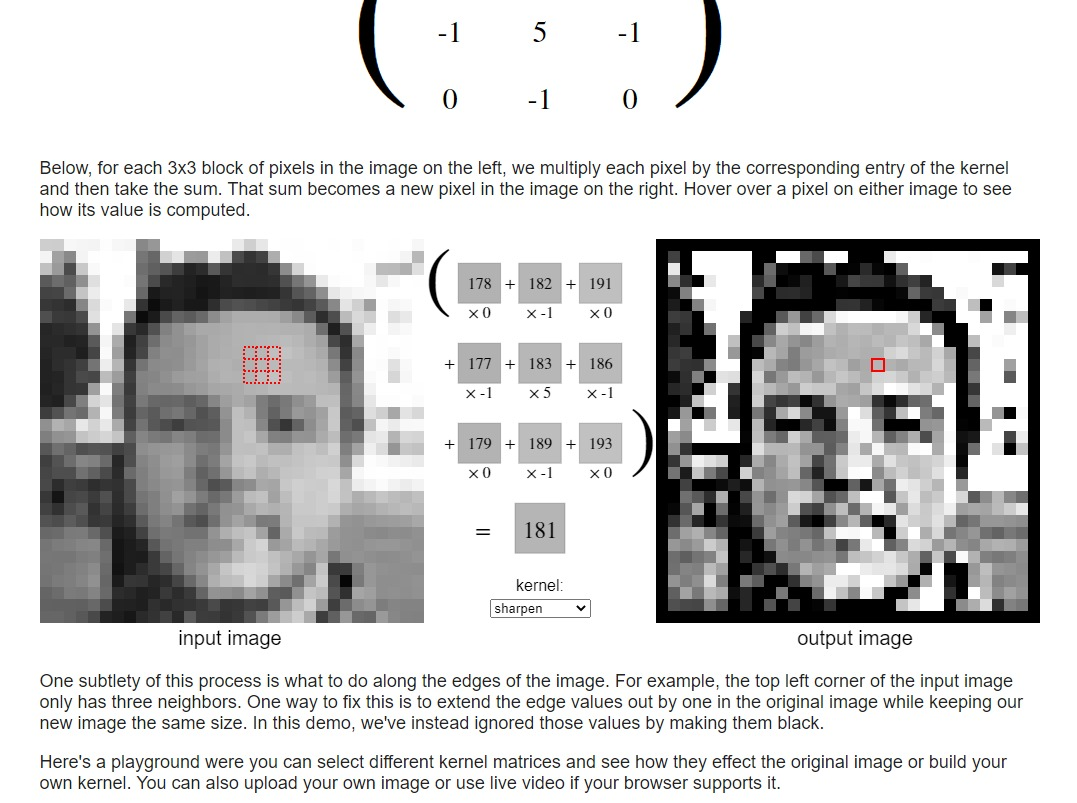

## Exemplos de aplicação de filtros
A biblioteca OpenCV possui diversas funções pré definidas baseadas em convolução como `cv.blur()`, `cv.Canny()` e `cv.blur()`. Elas diferem entre si, teoricamente, pelo tipo de kernel utilizado e em otimizações ponuais baseadas na característica de cada filtro e como as atualizações são feitas no acumulador. Mas, para fins didáticos, vamos tentar utilizar a função mais geral `cv.filter2d()` com kernels adequados para simular tais implementações e mostrar o funcionamento da teoria. 


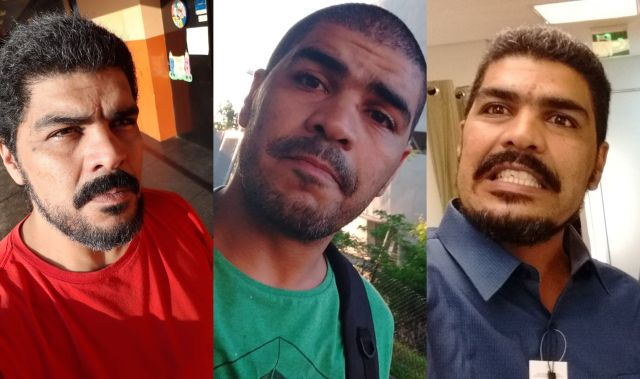

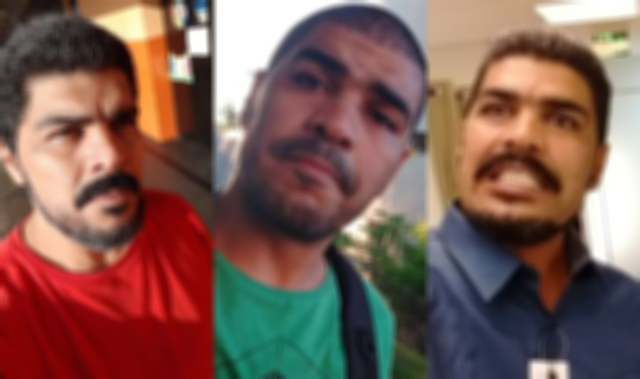

In [17]:
show(img)

kernelBlur = np.ones((8, 8), np.float32)/64
imgBlur = cv.filter2D(img, -1, kernelBlur)
show(imgBlur)

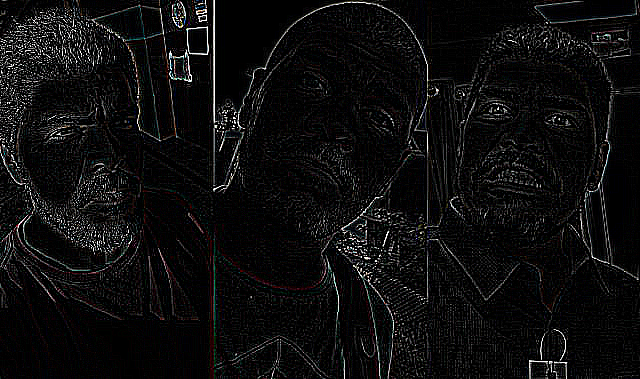

In [19]:
kernelFindedges = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1],
])
imgFindEdg = cv.filter2D(img, -1, kernelFindedges)
show(imgFindEdg)

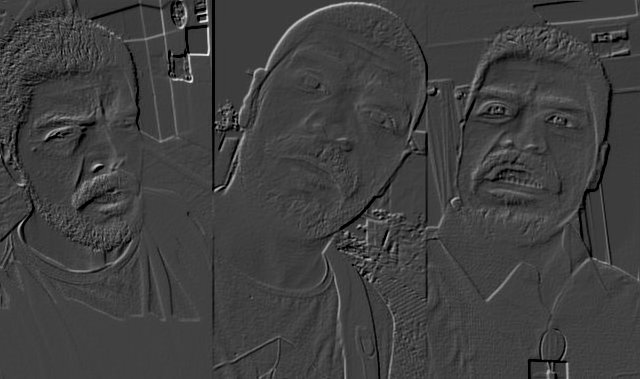

In [84]:
kernelEmboss = np.array([
    [-2, -1, 0],
    [-1, .1, 1],
    [0, 1, 2]
])


imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
imgContrast = -imgGray/4 + 600
imgEmboss = cv.filter2D(imgContrast, -1, kernelEmboss)
show(imgEmboss)

# CONCLUSÃO
Convolução nos permite pensar em um tipo diferente de mapeamento de valores numa função onde, no nosso caso com processamento de imagens, a entrada é uma função 2D (que representa a imagem) e uma matriz kernel que representa o filtro a ser aplicado. Como resultado temos, não apenas a modificação da função mas a relação entre diversos 'tempos' da função de forma a acessarmos e reunirmos informação de trechos diferentes da imagem na forma de um operador materializado no kernel. Diferentes kernels resultam em diversos efeitos. 

página do github: https://elsioantunes.github.io/proc-video/
